In [1]:
import os
import itertools
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

Train images shape:  (10000, 96, 96, 3)
Train labels shape:  (10000, 12, 12)
Weights shape: (10000, 12, 12)


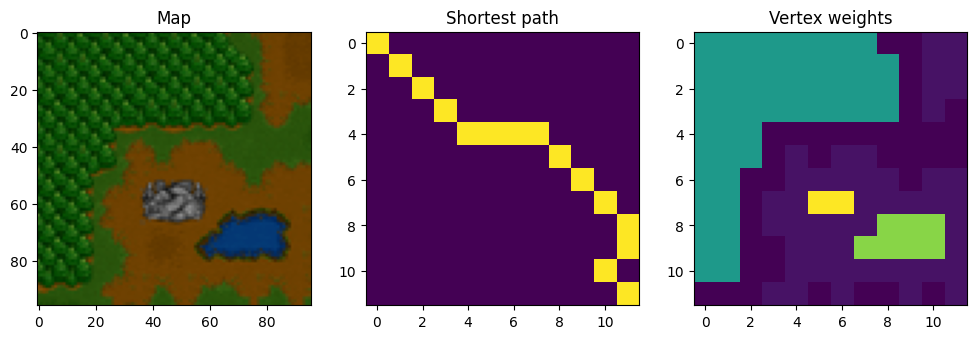

In [2]:
data_dir = './../data/warcraft_shortest_path_oneskin/12x12/'

data_suffix = "maps"
train_prefix = "train"


train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy"))
train_weights = np.load(os.path.join(data_dir, train_prefix + "_vertex_weights.npy"))
train_labels = np.load(os.path.join(data_dir, train_prefix + "_shortest_paths.npy"))

#images = train_inputs.transpose(0,2,3,1).astype(np.uint8)
images = train_inputs

print("Train images shape: ", train_inputs.shape)
print("Train labels shape: ",  train_labels.shape)
print("Weights shape:", train_weights.shape)

idx = 9
im = images[idx]
label = train_labels[idx]
weights = train_weights[idx]


fig, ax = plt.subplots(1,3, figsize=(12,12))

ax[0].imshow(im.astype(np.uint8))
ax[0].set_title("Map")
ax[1].imshow(label)
ax[1].set_title("Shortest path")
ax[2].set_title("Vertex weights")
ax[2].imshow(weights.astype(np.float32))

In [13]:
# 四角形の辺の中点にそれぞれ，a, b, c, d の記号を割り当てる
# マス目に何もない場合は，oo とする
symbol_list = ['ab', 'ac', 'ad', 'bc', 'bd', 'cd', 'oo']
print(f'all directions: {symbol_list}')
print()

combinations_list = list(itertools.combinations_with_replacement(symbol_list, 9))

# for i in range(10):
#     combinations = combinations_list[i]
#     direction_matrix = np.reshape(combinations, (3,3))
#     print(direction_matrix)
#     print()

direction_matrix_list = [np.reshape(combinations, (3,3)) for combinations in combinations_list]
print(f'number of combinations: {len(direction_matrix_list)}')
print()

# 3つの方向行列をランダムに選ぶ
random_direction_matrices = random.sample(direction_matrix_list, 3)
for direction_matrix in random_direction_matrices:
    print(direction_matrix)
    print()


all directions: ['ab', 'ac', 'ad', 'bc', 'bd', 'cd', 'oo']

number of combinations: 5005

[['ab' 'ab' 'ab']
 ['ab' 'ab' 'bc']
 ['bd' 'bd' 'cd']]

[['ab' 'ab' 'ad']
 ['ad' 'bc' 'bc']
 ['bc' 'oo' 'oo']]

[['ab' 'ac' 'ad']
 ['ad' 'ad' 'bc']
 ['bd' 'cd' 'oo']]



In [2]:
direction_matrix = np.array([
    ['ad', 'oo', 'oo'],
    ['bc', 'ac', 'ad'],
    ['oo', 'oo', 'bd']
])

print('direction matrix:\n')
print(direction_matrix)
print()


def judge_continuity(d_from: str, current_direction: str) -> bool:
    if d_from == 'a' and 'c' in current_direction:
        return True
    elif d_from == 'c' and 'a' in current_direction:
        return True
    elif d_from == 'b' and 'd' in current_direction:
        return True 
    elif d_from == 'd' and 'b' in current_direction:
        return True
    else:
        return False
    
def get_next_coordinate(d_to: str, current: tuple[int, int]) -> tuple[int, int]:
    next_dict = {
        'a': (-1, 0),
        'b': (0, -1),
        'c': (0, 1),
        'd': (1, 0)
    }
    next_coordinate = (current[0] + next_dict[d_to][0], current[1] + next_dict[d_to][1])
    return next_coordinate

def judge_location_validity(current: tuple[int, int], shape: tuple[int, int]) -> bool:
    if current[0] < 0 or current[0] >= shape[0] or current[1] < 0 or current[1] >= shape[1]:
        return False
    else:
        return True
    
def get_d_to(d_from: str, current: str) -> str:
    d_to = current[0] if current[0] != d_from else current[1]
    return d_to

def get_d_from(d_to: str) -> str:
    if d_to == 'a':
        d_from = 'c'
    elif d_to == 'b':
        d_from = 'd'
    elif d_to == 'c':
        d_from = 'a'
    elif d_to == 'd':
        d_from = 'b'
    else:
        raise ValueError
    return d_from


direction matrix:

[['ad' 'oo' 'oo']
 ['bc' 'ac' 'ad']
 ['oo' 'oo' 'bd']]



In [4]:
def judge_location_validity(pos, shape):
    return 0 <= pos[0] < shape[0] and 0 <= pos[1] < shape[1]

def judge_continuity(direction, next_direction):
    # next_direction はタプルの方向文字列を前提とします
    return direction in next_direction

def get_d_from(d_to):
    # 逆方向を返す関数（例: 'd' -> 'u', 'r' -> 'l' 等）
    opposite = {'d': 'u', 'u': 'd', 'l': 'r', 'r': 'l'}
    return opposite[d_to]

def get_d_to(d_from, direction):
    # 方向を決定する関数（ここでは仮に同じ方向を返す）
    return direction.replace(d_from, '')


In [6]:
direction_matrix = np.array([
    ['ad', 'oo', 'oo'],
    ['bc', 'ac', 'ad'],
    ['oo', 'oo', 'bd']
])

history = []

current = (0,0)
goal = (2,2)

shape = direction_matrix.shape

history.append(current)
print(f'history: {history}')

# initial_valid_directions = ['ac', 'ad', 'bc', 'bc']

direction = direction_matrix[current]
print(f'direction: {direction}')
d_to = direction[1]
print(f'd_to: {d_to}')

next_pos = get_next_coordinate(d_to, current)

next_pos_flag = judge_location_validity(next_pos, shape)
# continuity_flag = judge_continuity(d_to, direction_matrix[current])
continuity_flag = True

# print(f'next_pos: {next_pos}')
# print(f'next_pos_flag: {next_pos_flag}')
# print(f'continuity_flag: {continuity_flag}')


# while judge_location_validity(current, shape) and judge_continuity(d_to, direction_matrix[current]) and current != goal:
while next_pos_flag and continuity_flag and current != goal:    
    d_from = get_d_from(d_to)
    current = next_pos
    direction = direction_matrix[current]
    d_to = get_d_to(d_from, direction)

    # print()
    # print(f'in while loop')
    # print(f'current: {current}')
    # print(f'direction: {direction}')
    # print(f'd_to: {d_to}')

    history.append(current)

    if current == goal:
        break

    next_pos = get_next_coordinate(d_to, current)
    next_pos_flag = judge_location_validity(next_pos, shape)
    continuity_flag = judge_continuity(d_to, direction_matrix[next_pos])

    # print()
    # print(f'next_pos: {next_pos}')
    # print(f'next_pos_flag: {next_pos_flag}')
    # print(f'continuity_flag: {continuity_flag}')


print()
print(f'history: {history}')

history: [(0, 0)]
direction: ad
d_to: d

history: [(0, 0), (1, 0), (1, 1), (1, 2), (2, 2)]


# 明示的に "o" の処理をしないといけない

In [3]:
import numpy as np

def navigate_through_matrix(direction_matrix, start, goal):

    history = []
    current = start
    shape = direction_matrix.shape
    direction = direction_matrix[current]
    if 'bd' not in direction:
        return history 
    
    history.append(current)
    d_to = direction[1]
    next_pos = get_next_coordinate(d_to, current)
    next_pos_flag = judge_location_validity(next_pos, shape)
    continuity_flag = True

    while next_pos_flag and continuity_flag and current != goal:
        d_from = get_d_from(d_to)
        current = next_pos
        direction = direction_matrix[current]
        d_to = get_d_to(d_from, direction)
        history.append(current)
        if current == goal:
            break
        next_pos = get_next_coordinate(d_to, current)
        next_pos_flag = judge_location_validity(next_pos, shape)
        continuity_flag = judge_continuity(d_to, direction_matrix[next_pos])

    return history

# Example usage:
direction_matrix = np.array([
    ['ad', 'oo', 'oo'],
    ['bc', 'ac', 'ad'],
    ['oo', 'oo', 'bd']
])

start = (0,0)
goal = (2,2)
history = navigate_through_matrix(direction_matrix, start, goal)
print(f'history: {history}')

history: []


In [9]:
# Example usage:
direction_matrix = np.array([
    ['ad', 'oo', 'oo'],
    ['bc', 'oo', 'ad'],
    ['oo', 'oo', 'bd']
])

start = (0,0)
goal = (2,2)
history = navigate_through_matrix(direction_matrix, start, goal)
print(f'history: {history}')

history: []


In [10]:
# Example usage:
direction_matrix = np.array([
    ['bd', 'oo', 'oo'],
    ['bc', 'ac', 'ad'],
    ['oo', 'oo', 'bd']
])

start = (0,0)
goal = (2,2)
history = navigate_through_matrix(direction_matrix, start, goal)
print(f'history: {history}')

history: [(0, 0), (1, 0), (1, 1), (1, 2), (2, 2)]


In [94]:

weights = np.array(
    [
        [0.1, 0.4, 0.9],
        [0.4, 0.1, 0.4],
        [0.9, 0.4, 0.1]
    ]
)

weight_sum = weights.sum()
if weight_sum > 1:
    weights = weights / weight_sum


np.float64(3.7)

In [4]:
def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])


manhattan_distance((0,0), (2,2))

4

In [5]:
import optuna
import numpy as np

weights = np.array(
    [
        [0.1, 0.4, 0.9],
        [0.4, 0.1, 0.4],
        [0.9, 0.4, 0.1]
    ]
)

weight_sum = weights.sum()
if weight_sum > 1:
    weights = weights / weight_sum

print(f'weights:\n {weights}')


def objective(trial):
    # Define the search space for each element of the 3x3 matrix
    directions = ['oo', 'ab', 'ac', 'ad', 'bc', 'bd', 'cd']
    direction_matrix = np.zeros((3, 3), dtype=object)
    for i in range(3):
        for j in range(3):
            direction_matrix[i, j] = trial.suggest_categorical(f'entry_{i}{j}', directions)

    print(f'direction matrix: {direction_matrix}')
    print()
    
    start = (0,0)
    goal = (2,2)
    history = navigate_through_matrix(direction_matrix, start, goal)

    if history:
        path_weight = sum(weights[coord] for coord in history)
        norm_const = manhattan_distance(start, goal)
        score1 = 1 - manhattan_distance(history[-1], goal) / norm_const + path_weight
    else:
        score1 = 1

    # Compute the score
    score2 = 0.0
    for i in range(3):
        for j in range(3):
            direction = direction_matrix[i, j]
            if direction == 'oo':
                continue
            score2 += weights[i, j]
    
    return score1 + score2

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)


[I 2024-07-07 18:02:19,670] A new study created in memory with name: no-name-579c1d01-9161-4819-969b-d1d287c68dc6
[I 2024-07-07 18:02:19,675] Trial 0 finished with value: 2.0 and parameters: {'entry_00': 'ab', 'entry_01': 'bd', 'entry_02': 'bc', 'entry_10': 'ac', 'entry_11': 'bc', 'entry_12': 'cd', 'entry_20': 'ad', 'entry_21': 'ac', 'entry_22': 'cd'}. Best is trial 0 with value: 2.0.
[I 2024-07-07 18:02:19,681] Trial 1 finished with value: 1.5405405405405406 and parameters: {'entry_00': 'bc', 'entry_01': 'oo', 'entry_02': 'ab', 'entry_10': 'cd', 'entry_11': 'cd', 'entry_12': 'oo', 'entry_20': 'oo', 'entry_21': 'ad', 'entry_22': 'cd'}. Best is trial 1 with value: 1.5405405405405406.
[I 2024-07-07 18:02:19,683] Trial 2 finished with value: 1.4864864864864864 and parameters: {'entry_00': 'ad', 'entry_01': 'bc', 'entry_02': 'ab', 'entry_10': 'oo', 'entry_11': 'oo', 'entry_12': 'oo', 'entry_20': 'oo', 'entry_21': 'ad', 'entry_22': 'oo'}. Best is trial 2 with value: 1.4864864864864864.
[W 2

weights:
 [[0.02702703 0.10810811 0.24324324]
 [0.10810811 0.02702703 0.10810811]
 [0.24324324 0.10810811 0.02702703]]
direction matrix: [['ab' 'bd' 'bc']
 ['ac' 'bc' 'cd']
 ['ad' 'ac' 'cd']]

direction matrix: [['bc' 'oo' 'ab']
 ['cd' 'cd' 'oo']
 ['oo' 'ad' 'cd']]

direction matrix: [['ad' 'bc' 'ab']
 ['oo' 'oo' 'oo']
 ['oo' 'ad' 'oo']]

direction matrix: [['bd' 'ab' 'cd']
 ['oo' 'ac' 'ab']
 ['bd' 'bd' 'bd']]



KeyError: 'o'

In [13]:
optuna.visualization.plot_optimization_history(study)